In [63]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from tensorflow.keras import regularizers
import keras


In [2]:
np.random.seed(42)

In [4]:
os.listdir("C:/Users/tirek/OneDrive/Masaüstü/emotion_from_image")

['.git', 'data', 'emotion_model.ipynb', 'Resimler', 'todo']

In [5]:
DATADIR = r"C:/Users/tirek/OneDrive/Masaüstü/emotion_from_image/data"

In [6]:
CATEGORIES = os.listdir(DATADIR)
CATEGORIES

['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']

In [7]:
from PIL import Image

def load_data(img_size=48):
    DATADIR = r'C:/Users/tirek/OneDrive/Masaüstü/emotion_from_image/data'
    data = []

    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)

        if not os.path.exists(path):
            print(f"Warning: {path} does not exist. Skipping...")
            continue

        for img_name in tqdm(os.listdir(path), desc=f"Processing {category}"):
            if not img_name.lower().endswith('.png'):
                continue

            img_path = os.path.join(path, img_name)

            try:
                img = Image.open(img_path).convert('L')
                img = img.resize((img_size, img_size))
                img_array = np.array(img) / 255.0
                data.append([img_array, class_num])
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
                continue

    
    return data


In [8]:
data=load_data()

Processing surprise: 100%|██████████| 249/249 [00:00<00:00, 3947.92it/s]


In [9]:
print(data)

[[array([[0.09411765, 0.03921569, 0.05098039, ..., 0.1372549 , 0.63921569,
        0.97254902],
       [0.06666667, 0.03529412, 0.06666667, ..., 0.05490196, 0.39607843,
        0.92156863],
       [0.03921569, 0.04705882, 0.06666667, ..., 0.01568627, 0.16862745,
        0.78823529],
       ...,
       [0.87058824, 0.87843137, 0.87843137, ..., 0.60392157, 0.60784314,
        0.61960784],
       [0.89411765, 0.89803922, 0.89803922, ..., 0.59607843, 0.60784314,
        0.61960784],
       [0.91764706, 0.92156863, 0.91372549, ..., 0.58823529, 0.6       ,
        0.61176471]]), 0], [array([[0.06666667, 0.03921569, 0.0627451 , ..., 0.08235294, 0.53333333,
        0.95294118],
       [0.04705882, 0.04705882, 0.07058824, ..., 0.03529412, 0.30196078,
        0.8627451 ],
       [0.03529412, 0.0627451 , 0.06666667, ..., 0.01568627, 0.12156863,
        0.69019608],
       ...,
       [0.86666667, 0.8745098 , 0.87058824, ..., 0.60784314, 0.61176471,
        0.61568627],
       [0.89019608, 0.89019

In [10]:
len(data)

981

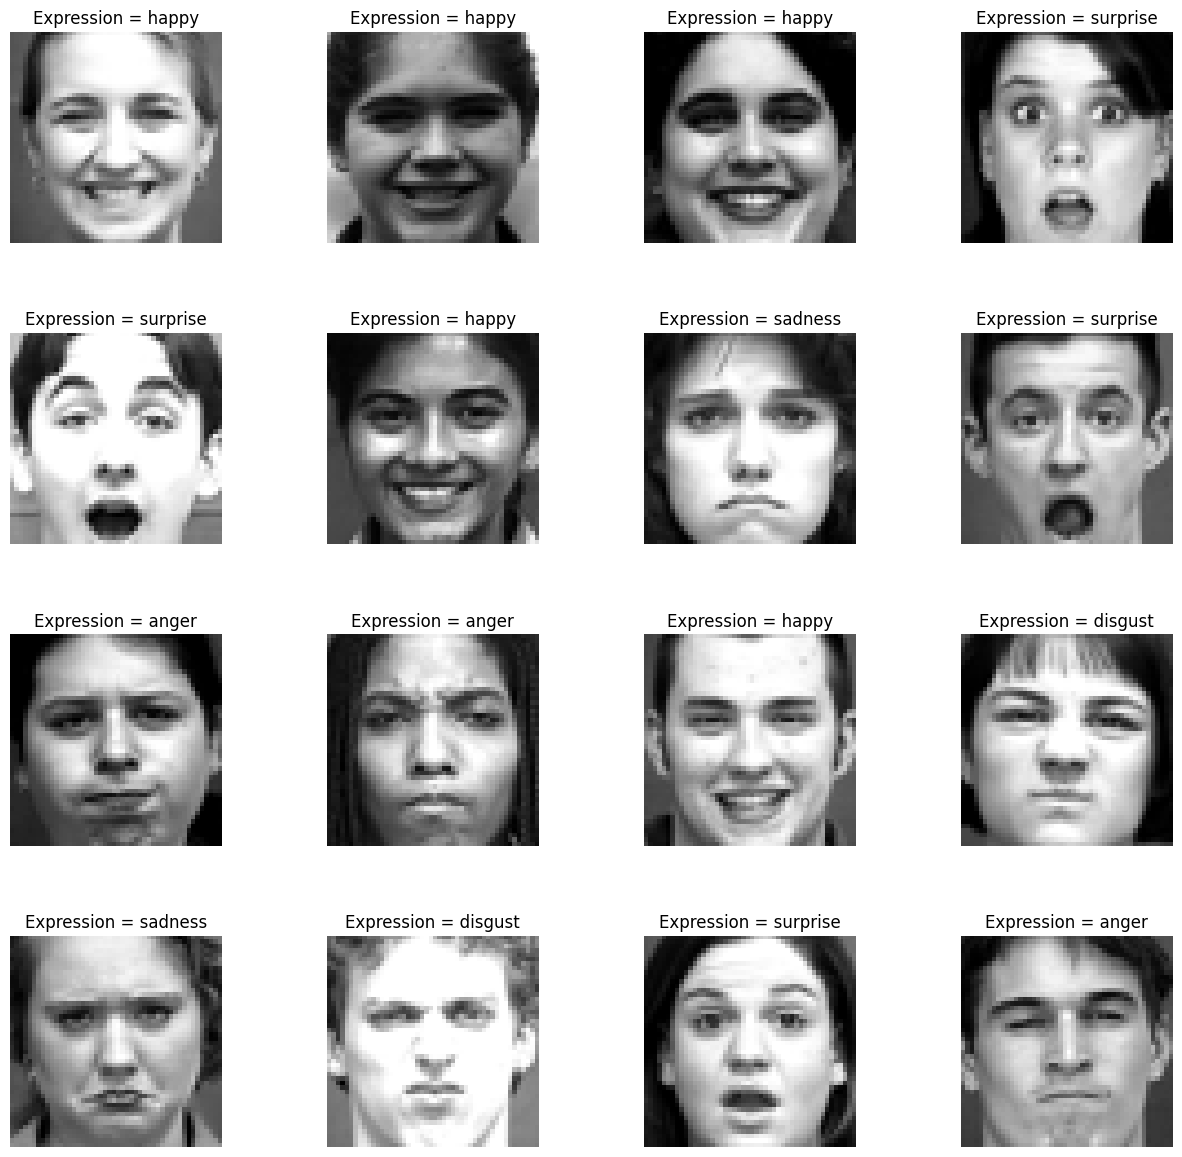

In [11]:
L = 4
W = 4
fig, axes = plt.subplots(L, W, figsize = (15,15))
axes = axes.ravel()

for i in range(0, L * W):  
    sample = random.choice(data)

    axes[i].set_title("Expression = "+str(CATEGORIES[sample[1]]))
    axes[i].imshow(sample[0], cmap='gray')
    axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)

In [12]:
X = np.array([ x[0] for x in data])
y = np.array([Y[1] for Y in data])

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)

In [15]:
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("-------------------------------")
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (784, 48, 48)
y_train shape:  (784,)
-------------------------------
X_test shape:  (197, 48, 48)
y_test shape:  (197,)


In [16]:
# reshaping y_train and y_test
y_train = np.reshape(y_train, (len(y_train),1))
y_test  = np.reshape(y_test , (len(y_test ),1))

print("After reshaping")
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

After reshaping
y_train shape:  (784, 1)
y_test shape:  (197, 1)


In [17]:
X_train_Gabor  = X_train
X_test_Gabor = X_test

In [18]:
X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)

print("After adding color channel")
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)

After adding color channel
X_train shape:  (784, 48, 48, 1)
X_test shape:  (197, 48, 48, 1)


In [19]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [20]:
y_train[0]

array([6])

In [21]:
y_train_SVM = y_train
y_test_SVM = y_test

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [22]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 1.])

In [23]:
y_train.shape, y_test.shape

((784, 7), (197, 7))

FEATURE EXTRACTION

In [24]:
from skimage.transform import resize
from skimage.feature import hog

(np.float64(-0.5), np.float64(47.5), np.float64(47.5), np.float64(-0.5))

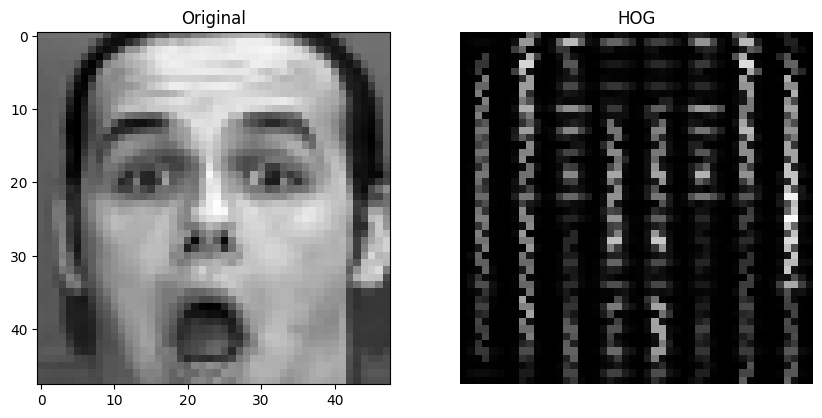

In [25]:
from skimage.feature import hog
from skimage.transform import resize
import matplotlib.pyplot as plt
import random

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
img = random.choice(X_train)

# Resize image to (128, 64) as required by HOG descriptor
resized_img = resize(img, (128, 64)).squeeze()  # from (128,64,1) to (128,64)

plt.title("Original")
plt.imshow(img.squeeze(), cmap='gray')  # squeeze: gereksiz 4. boyutu atmak için

# Apply HOG (no need for multichannel since it's grayscale)
fd, hog_image = hog(
    resized_img,
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    visualize=True
)

plt.subplot(1, 2, 2)
plt.title("HOG")
plt.imshow(resize(hog_image, (48, 48)), cmap='gray')
plt.axis('off')


In [26]:
def Create_Hog_features(data):
    Feature_data = np.zeros((len(data),48,48))

    for i in range(len(data)):
        img = data[i]
        resized_img = resize(img, (128, 64))
        fd, hog_image = hog(
        resized_img.squeeze(),  # 2D yapıyoruz
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        visualize=True
)

        Feature_data[i] = resize(hog_image, (48, 48))
    return Feature_data

In [27]:
Feature_X_train = Create_Hog_features(X_train)
Feature_X_train.shape

(784, 48, 48)

(np.float64(-0.5), np.float64(47.5), np.float64(47.5), np.float64(-0.5))

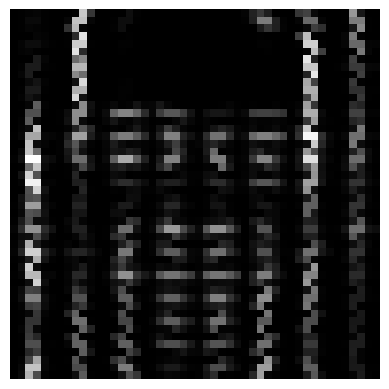

In [28]:
plt.imshow(random.choice(Feature_X_train), cmap='gray')
plt.axis('off')

In [29]:
# doing same for test data 
Feature_X_test = Create_Hog_features(X_test)

Feature_X_test.shape

(197, 48, 48)

(np.float64(-0.5), np.float64(47.5), np.float64(47.5), np.float64(-0.5))

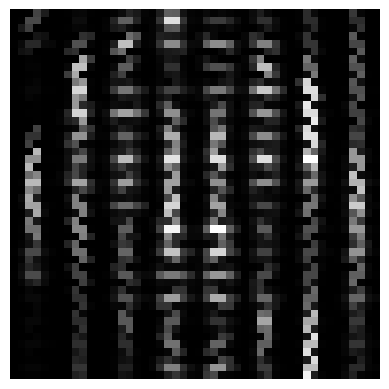

In [30]:
plt.imshow(random.choice(Feature_X_test), cmap='gray')
plt.axis('off')

In [31]:
# Again adding color channel as it got removed while converting img to hog img
X_train_HOG = np.expand_dims(Feature_X_train, axis=3)
X_test_HOG = np.expand_dims(Feature_X_test, axis=3)

print("After adding color channel")
print("X_train_HOG shape: ", X_train_HOG.shape)
print("X_test_HOG shape: ", X_test_HOG.shape)

After adding color channel
X_train_HOG shape:  (784, 48, 48, 1)
X_test_HOG shape:  (197, 48, 48, 1)


In [32]:
print("X_train_HOG shape: ", X_train_HOG.shape)
print("y_train shape: ", y_train.shape)
print("X_test_HOG shape: ", X_test_HOG.shape)
print("y_test shape: ", y_test.shape)

X_train_HOG shape:  (784, 48, 48, 1)
y_train shape:  (784, 7)
X_test_HOG shape:  (197, 48, 48, 1)
y_test shape:  (197, 7)


In [33]:
def create_model(input_shape=None):
    if input_shape is None :
        input_shape=(48,48,1)

    model = Sequential()
    model.add(Conv2D(6, (5, 5), input_shape=input_shape, padding='same', activation = 'relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(16, (5, 5), padding='same', activation = 'relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(7, activation = 'softmax'))
    
    return model 

In [34]:
es = EarlyStopping(
    monitor='val_accuracy', min_delta=0.0001, patience=10, verbose=2,
    mode='max', baseline=None, restore_best_weights=True
)
lr = ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=5, verbose=2,
    mode='max', min_delta=1e-5, cooldown=0, min_lr=0
)

callbacks = [es, lr]

In [37]:
HOG_model = create_model()

c:\Users\tirek\anaconda3\envs\ML\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [38]:
HOG_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 64)     │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 217,683 (850.32 KB)

 Trainable params: 217,683 (850.32 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
HOG_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam' )

In [40]:
HOG_history = HOG_model.fit(X_train_HOG, y_train, batch_size=8 , epochs=50, validation_data = (X_test_HOG, y_test), callbacks = [callbacks])

Epoch 1/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2432 - loss: 1.8825 - val_accuracy: 0.2284 - val_loss: 1.8327 - learning_rate: 0.0010
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2579 - loss: 1.8499 - val_accuracy: 0.2284 - val_loss: 1.8293 - learning_rate: 0.0010
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2672 - loss: 1.8488 - val_accuracy: 0.2284 - val_loss: 1.8291 - learning_rate: 0.0010
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2020 - loss: 1.8304 - val_accuracy: 0.2284 - val_loss: 1.8342 - learning_rate: 0.0010
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2491 - loss: 1.8329 - val_accuracy: 0.2284 - val_loss: 1.8349 - learning_rate: 0.0010
Epoch 6/50
88/98 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2488 - loss: 1.8263
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2504 - loss: 1.8260 - val_accuracy:

In [41]:
def plot_performance(history):
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')

    plt.legend()
    plt.grid()
    plt.title('train and val loss evolution')

    plt.subplot(2, 1, 2)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')

    plt.legend()
    plt.grid()
    plt.title('train and val accuracy')

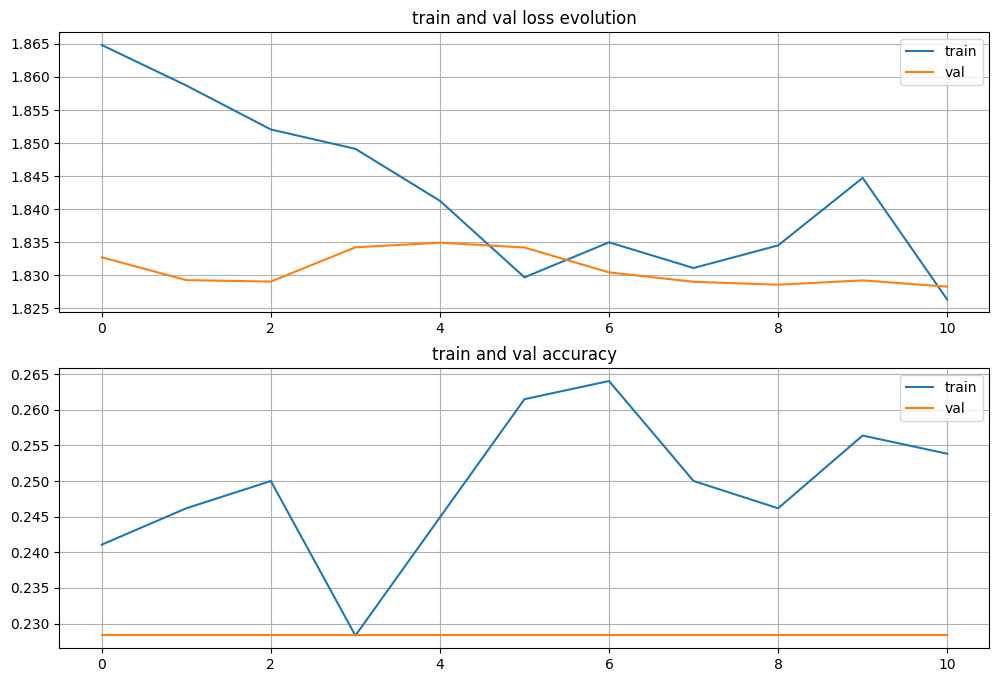

In [42]:
plot_performance(HOG_history)

In [43]:
acc=[]

In [45]:
HOG_acc = HOG_model.evaluate(X_test_HOG, y_test, verbose = 0)[1]
acc.append(HOG_acc)
print("HOG Accuracy :",HOG_model.evaluate(X_test_HOG, y_test, verbose = 0)[1])

HOG Accuracy : 0.22842639684677124


lbp

In [46]:
def Binarypattern(im):                               # creating function to get local binary pattern
    img= np.zeros_like(im)
    n=3                                              # taking kernel of size 3*3
    for i in range(0,im.shape[0]-n):                 # for image height
        for j in range(0,im.shape[1]-n):               # for image width
            x  = im[i:i+n,j:j+n]                     # reading the entire image in 3*3 format
            center       = x[1,1]                    # taking the center value for 3*3 kernel
            img1        = (x >= center)*1.0          # checking if neighbouring values of center value is greater or less than center value
            img1_vector = img1.T.flatten()           # getting the image pixel values 
            img1_vector = np.delete(img1_vector,4)  
            digit = np.where(img1_vector)[0]         
            if len(digit) >= 1:                     # converting the neighbouring pixels according to center pixel value
                num = np.sum(2**digit)              # if n> center assign 1 and if n<center assign 0
            else:                                    # if 1 then multiply by 2^digit and if 0 then making value 0 and aggregating all the values of kernel to get new center value
                num = 0
            img[i+1,j+1] = num
    return(img)

(np.float64(-0.5), np.float64(47.5), np.float64(47.5), np.float64(-0.5))

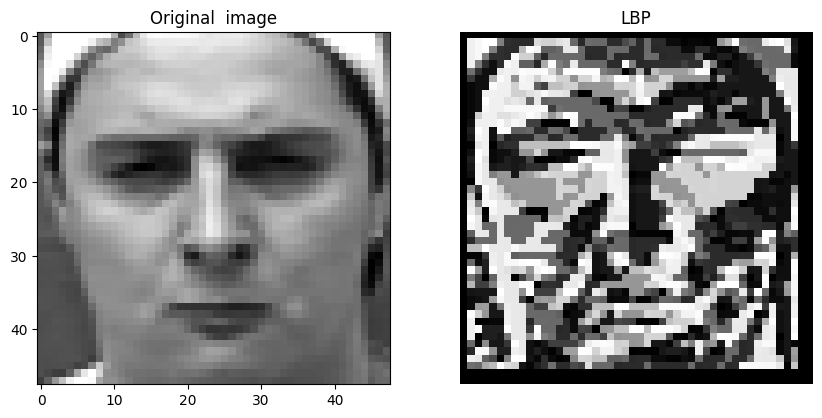

In [47]:
plt.figure(figsize = (10,10))

plt.subplot(1,2,1)
img = random.choice(X_train)
plt.title("Original  image")
plt.imshow(img, cmap='gray')

plt.subplot(1,2,2)
plt.title("LBP")
imgLBP=Binarypattern(img)             # calling the LBP function using gray image
plt.imshow(imgLBP, cmap='gray')
plt.axis('off')

In [48]:
X_train.shape

(784, 48, 48, 1)

In [50]:
def create_LBP_features(data):
    Feature_data = np.zeros(data.shape)

    for i in range(len(data)):
        img = data[i]
        imgLBP=Binarypattern(img)  
        Feature_data[i] = imgLBP
    
    return Feature_data

In [51]:
Feature_X_train = create_LBP_features(X_train)


In [52]:
Feature_X_train.shape

(784, 48, 48, 1)

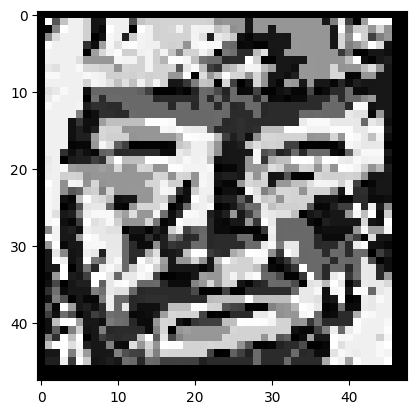

In [53]:
img = random.choice(Feature_X_train)
plt.imshow(img, cmap='gray')

In [54]:
Feature_X_test = create_LBP_features(X_test)
Feature_X_test.shape

(197, 48, 48, 1)

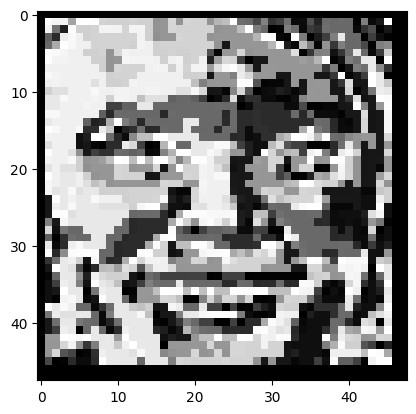

In [55]:
img = random.choice(Feature_X_test)
plt.imshow(img, cmap='gray')

In [56]:
LBP_model = create_model()
LBP_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam' )

c:\Users\tirek\anaconda3\envs\ML\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [57]:
LBP_history = LBP_model.fit(Feature_X_train, y_train, batch_size=8 , epochs=50, validation_data = (Feature_X_test, y_test) ,callbacks = [callbacks])

Epoch 1/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.1895 - loss: 14.4220 - val_accuracy: 0.3249 - val_loss: 1.6908 - learning_rate: 0.0010
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3742 - loss: 1.5854 - val_accuracy: 0.5685 - val_loss: 1.2800 - learning_rate: 0.0010
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4979 - loss: 1.3634 - val_accuracy: 0.5888 - val_loss: 1.1216 - learning_rate: 0.0010
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6467 - loss: 0.9630 - val_accuracy: 0.7107 - val_loss: 0.8224 - learning_rate: 0.0010
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7676 - loss: 0.6962 - val_accuracy: 0.7766 - val_loss: 0.5544 - learning_rate: 0.0010
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8280 - loss: 0.4804 - val_accuracy: 0.8071 - val_loss: 0.5307 - learning_rate: 0.0010
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8430 - loss: 0.4287 - val_accuracy

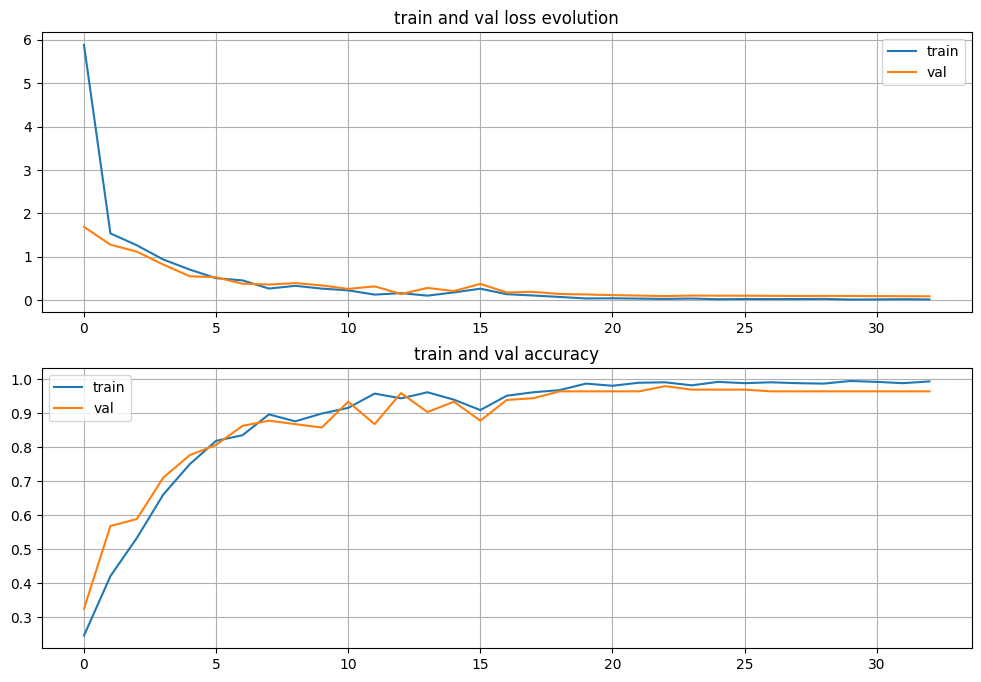

In [58]:
plot_performance(LBP_history)

In [59]:
LBP_acc = LBP_model.evaluate(Feature_X_test, y_test, verbose = 0)[1]
acc.append(LBP_acc)
print("LBP Accuracy :",LBP_model.evaluate(Feature_X_test, y_test, verbose = 0)[1])

LBP Accuracy : 0.9796954393386841


In [65]:
keras.saving.save_model(LBP_model, 'lbp_emotion_model.keras')